# min(DALL·E)

This is a fast, minimal port of Boris Dayma's [DALL·E Mini](https://github.com/borisdayma/dalle-mini) (with mega weights).  It has been stripped down for inference and converted to PyTorch.  The only third party dependencies are numpy, requests, pillow and torch.

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
%cd /content/drive/MyDrive/PhD/2022 Julen Etxaniz EHU/MAL/winoground/generation

/content/drive/MyDrive/PhD/2022 Julen Etxaniz EHU/MAL/winoground/generation


# Install Dependencies

In [3]:
!pip install min-dalle
!pip install datasets

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Created wheel for min-dalle: filename=min_dalle-0.4.0-py3-none-any.whl size=10410 sha256=af88c082ed37c610651cc5fef26621f685dec5cf23bd1f01abe6248b76f88dc6
  Stored in directory: /root/.cache/pip/wheels/d3/ed/4c/f7dfa1a41177885b973ab053ab39ad9ece98fa5d69809a4ab3
Successfully built min-dalle
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 362 kB 31.2 MB/s 
     |████████████████████████████████| 212 kB 73.9 MB/s 
     |████████████████████████████████| 1.1 MB 59.0 MB/s 
     |████████████████████████████████| 101 kB 15.0 MB/s 
     |████████████████████████████████| 140 kB 76.4 MB/s 
     |████████████████████████████████| 596 kB 73.9 MB/s 
     |████████████████████████████████| 127 kB 78.3 MB/s 
     |████████████████████████████████| 271 kB 75.5 MB/s 
     |████████████████████████████████| 144 kB

# Load Winoground

Easily get a token by logging into https://huggingface.co/, clicking on your user profile -> settings -> access tokens -> new token

In [4]:
def get_token():
    with open("../token.txt") as f:
        return f.read()

In [5]:
from datasets import load_dataset
# Replace with an auth token, which you can get from your huggingface account: Profile -> Settings -> Access Tokens -> New Token
auth_token = get_token()
winoground = load_dataset("facebook/winoground", use_auth_token=auth_token)["test"]

Extracting data files:   0%|          | 0/2 [00:00<?, ?it/s]

Generating test split: 0 examples [00:00, ? examples/s]

Dataset winoground downloaded and prepared to /root/.cache/huggingface/datasets/facebook___winoground/default/0.0.0/ce486f3e39fab90997d6f3c58c4b0103eb9c37011049ef775a465f0ab2e78d7d. Subsequent calls will reuse this data.


  0%|          | 0/1 [00:00<?, ?it/s]

# Load Model

Load the model parameters once and reuse the model to generate multiple images.

The required models will be downloaded to `models_root` if they are not already there.  Set the `dtype` to `torch.float16` to save GPU memory. `float32` is faster than `float16` but uses more GPU memory.  Change the `grid_size` to 3 or less if using `float32`. If you have an Ampere architecture GPU you can use `torch.bfloat16`.  Set the `device` to either "cuda" or "cpu".


In [6]:
from IPython.display import display, update_display
import torch
from min_dalle import MinDalle

models_root = "/content/pretrained" #@param {type:"string"}
dtype = "float16" #@param ["float32", "float16", "bfloat16"]
device = "cuda" #@param ["cpu", "cuda"]
is_mega = True #@param {type:"boolean"}
is_reusable = True #@param {type:"boolean"}
is_verbose = True #@param {type:"boolean"}

model = MinDalle(
    models_root=models_root,
    dtype=getattr(torch, dtype),
    device=device,
    is_mega=is_mega, 
    is_reusable=is_reusable,
    is_verbose=is_verbose
)

using device cuda
downloading tokenizer params
intializing TextTokenizer
downloading encoder params
initializing DalleBartEncoder
downloading decoder params
initializing DalleBartDecoder
downloading detokenizer params
initializing VQGanDetokenizer


# Generate Images

Once everything has finished initializing, call `generate_image_stream` with some text as many times as you want. You can asjust input parameters to your needs.

## Basic

- `text`: For long prompts, only the first 64 tokens will be used to generate the image.

- `seed`: Use a positive seed for reproducible results.

- `grid_size`: Size of the image grid. Reduce this if you run out of GPU memory.

- `progressive_outputs`: Whether to show intermediate output.  Adds a small delay and increases memory usage.

- `is_seamless`: Tiles the images in token space instead of pixel space. This has the effect of blending the images at the borders.

## Advanced

- `temperature`: High temperature increases the probability of sampling low scoring image tokens.
- `top_k`: Each image token is sampled from the top-k scoring tokens.

Increasing `temperature` and/or `top_k` will increase variety in the generated images at the expense of the images being less coherent. Setting `temperature` high and `top_k` low can result in more variety without sacrificing coherence.

## Expert

- `supercondition_factor`: Higher values can result in better agreement with the text but a narrower variety of generated images. Let `logits_cond` be the logits computed from the text prompt and `logits_uncond` be the logits computed from an empty text prompt, and let `a` be the super-condition factor, then `logits = logits_cond * a + logits_uncond * (1 - a)`

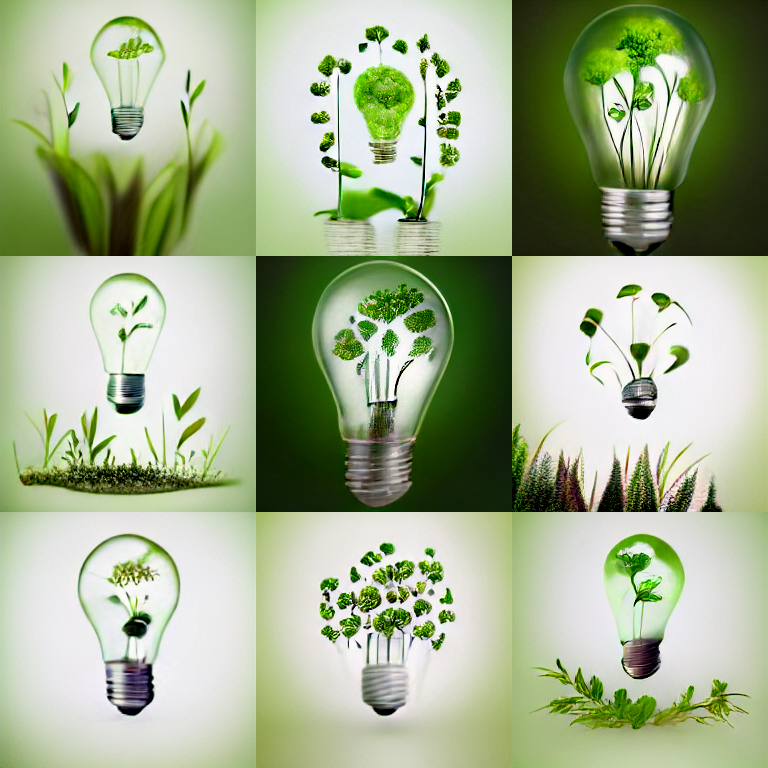

CPU times: user 26.5 s, sys: 490 ms, total: 27 s
Wall time: 34.3 s


In [7]:
%%time

text = "some plants surrounding a lightbulb" #@param {type:"string"}
seed = 1 #@param {type:"integer"}
grid_size = 3 #@param {type:"slider", min:1, max:9, step:1}
progressive_outputs = True #@param {type:"boolean"}
is_seamless = False #@param {type:"boolean"}
temperature = 1 #@param {type:"slider", min:0.01, max:16, step:0.01}
top_k = 256 #@param [1, 2, 4, 8, 16, 32, 64, 128, 256, 512, 1024, 2048, 4096, 8192, 16384]
supercondition_factor = 16 #@param [4, 8, 16, 32, 64]
is_verbose = False #@param {type:"boolean"}

image_stream = model.generate_image_stream(
    text=text,
    seed=seed,
    grid_size=grid_size,
    progressive_outputs=progressive_outputs,
    is_seamless=is_seamless,
    temperature=temperature,
    top_k=int(top_k),
    supercondition_factor=float(supercondition_factor),
    is_verbose=is_verbose
)

path = "../images/min_dalle"
id = 155
cap = 0
is_first = True
for images in image_stream:
    display_image = display if is_first else update_display
    display_image(images, display_id=1)
    is_first = False

images.save(f"{path}/ex_{id}_cap_{cap}_img.png")

In [18]:
images = model.generate_images(
    text=text,
    seed=seed,
    grid_size=grid_size,
    is_seamless=is_seamless,
    temperature=temperature,
    top_k=int(top_k),
    supercondition_factor=float(supercondition_factor),
    is_verbose=is_verbose
)

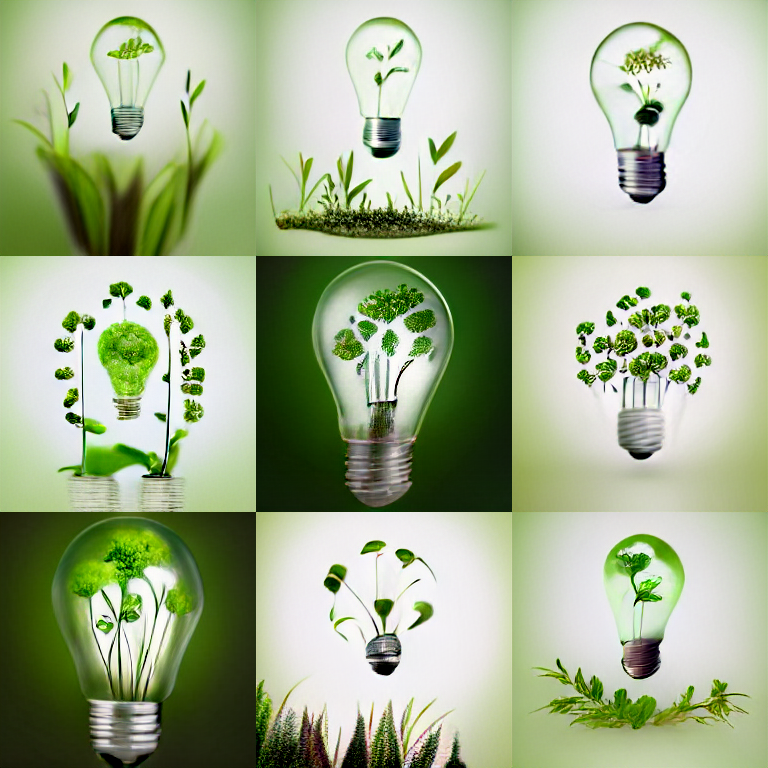

In [22]:
from PIL import Image
import numpy as np

images_np = images.to('cpu').numpy().astype(np.uint8)
# images_np = (images_np * 255).astype(np.uint8)

def image_grid(imgs, rows, cols):
    assert len(imgs) == rows*cols

    w, h = imgs[0].size
    grid = Image.new('RGB', size=(cols*w, rows*h))
    grid_w, grid_h = grid.size
    
    for i, img in enumerate(imgs):
        grid.paste(img, box=(i%cols*w, i//rows*h))
    return grid

images_pil = []
for i, image_np in enumerate(images_np):
    image = Image.fromarray(image_np)
    images_pil.append(image)
    image.save(f"{path}/ex_{id}_cap_{cap}_img_{i}.png")

image_grid = image_grid(images_pil, rows=grid_size, cols=grid_size)
display(image_grid)
image_grid.save(f"{path}/ex_{id}_cap_{cap}_img.png")

# Generate Winoground Images

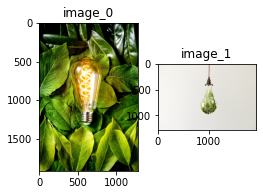

caption_0: some plants surrounding a lightbulb
caption_1: a lightbulb surrounding some plants


In [9]:
from matplotlib import pyplot as plt

def show_example(id):
    ax1 = plt.subplot(1, 3, 1)
    ax1.title.set_text('image_0')
    plt.imshow(winoground[id]["image_0"].convert("RGB"))

    ax2 = plt.subplot(1, 3, 2)
    ax2.title.set_text('image_1')
    plt.imshow(winoground[id]["image_1"].convert("RGB"))

    plt.show()

    print("caption_0:", winoground[id]["caption_0"])
    print("caption_1:", winoground[id]["caption_1"])

show_example(id=155)